<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/CLTV_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Customer Lifetime Value(CLTV)
"Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship" (Source). CLTV demonstrates the implications of acquiring long-term customers compare to short-term customers. Customer lifetime value (CLV) can help us to answers the most important questions about sales to every company: 
- How to Identify the most profitable customers?
- How can a company offer the best product and make the most money?
- How to segment profitable customers?
- How much budget need to spend to acquire customers?
##Calculate Customer Lifetime Value
There are lots of approaches available for calculating CLTV. Everyone has their own view on it. 
- We can compute it by adding profit/revenue from customers in a given cycle. For Example, if the customer is associated with the business for the last 3 years, we can sum all the profit in this 3 years. We can average the profit yearly or half-yearly or monthly, but in this approach, we won's be able to build a predictive model for new customers.
- Build a regression model for existing customers. Take recent six-month data as independent variables and total revenue over three years as a dependent variable and build a regression model on this data.
- CLTV can also implement using RFM(Recency, Frequency, Monetary) values. For more details, you can refer to my tutorial.
- Using the following equation: CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.
    -  Customer Value = Average Order Value * Purchase Frequency
    - Average Order Value(AOV) = Total Revenue / Total Number of Orders. AOV represents the mean amount of revenue that the customer spends on an order.
    - Purchase Frequency =  Total Number of Orders / Total Number of Customers. It represents the average number of orders placed by each customer.
    - Churn Rate: Churn Rate is the percentage of customers who have not ordered again.
    - Customer Lifetime = 1/ churn rate
    - Churn Rate= 1-Repeat Rate

In [2]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 584 kB 4.9 MB/s 


In [3]:
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
import io
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import xlrd
import pandas as pd
import datetime

#Importing Lifetimes Liabraries
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Online_Retail.xlsx to Online_Retail.xlsx


In [5]:
data = pd.read_excel(io.BytesIO(uploaded.get('Online_Retail.xlsx'))) #reading the excel file#

In [6]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



# **Data Preprocessing**

In [7]:
def check_df(dataframe):
    print("################ Shape ####################")
    print(dataframe.shape)
    print("############### Columns ###################")
    print(dataframe.columns)
    print("############### Types #####################")
    print(dataframe.dtypes)
    print("############### Head ######################")
    print(dataframe.head())
    print("############### Tail ######################")
    print(dataframe.tail())
    print("############### Describe ###################")
    print(dataframe.describe().T)

check_df(data)

################ Shape ####################
(541909, 8)
############### Columns ###################
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')
############### Types #####################
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
CustomerID            float64
Country                object
dtype: object
############### Head ######################
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   



In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   Price        541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
data.isnull().sum()/data.shape[0]*100

Invoice         0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [10]:
# first drop the rows where the description is null
data.dropna(axis = 0, subset = ["Description"], inplace = True)

In [11]:
data.isnull().sum() #Now let's check the data before droping these customer ID's

Invoice             0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
Price               0
CustomerID     133626
Country             0
dtype: int64

In [12]:
data[data["CustomerID"].isnull()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [13]:
data.iloc[575:, :]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
575,536412,22144,CHRISTMAS CRAFT LITTLE FRIENDS,2,2010-12-01 11:49:00,2.10,17920.0,United Kingdom
576,536412,22243,5 HOOK HANGER RED MAGIC TOADSTOOL,3,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
577,536412,22077,6 RIBBONS RUSTIC CHARM,7,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
579,536412,22759,SET OF 3 NOTEBOOKS IN PARCEL,5,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [14]:
# We have to drop the rows where customer ID is null because it's a unique customer ID of each customer
# So it's better to drop rather than imputing it with some random value

data.dropna(axis = 0, subset = ["CustomerID"], inplace = True)

In [15]:
data.isnull().sum() #Now's there is no null values available in our data

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
dtype: int64

In [16]:
data.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Removing Duplicates
Sometimes we get a messy dataset. we may have to deal with duplicates, which will skew your analysis. 

In [17]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

Let's Jump into Data Insights

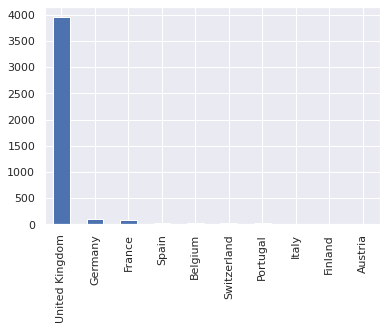

In [18]:
#Top ten country's customer
filtered_data.Country.value_counts()[:10].plot(kind='bar')
plt.show()

In [19]:
temp_df = pd.DataFrame(data["Country"].value_counts())

In [20]:
temp_df.head(10)

,Country
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,1877
Portugal,1480
Australia,1259


In [21]:
names  = temp_df.index

In [22]:
px.scatter(temp_df, y = "Country", color = names, title = "Count of Countries")

In [23]:
#Now let's check the total quantity and by country
data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).head(10)
#data.groupby("Country").sum()["Quantity"].sort_values(ascending = False).tail(10)

Country
United Kingdom    4008533
Netherlands        200128
EIRE               136329
Germany            117448
France             109848
Australia           83653
Sweden              35637
Switzerland         29778
Spain               26824
Japan               25218
Name: Quantity, dtype: int64

In [24]:
px.scatter(data.iloc[:, [5, 7]].groupby(["Country"]).mean(), 
           y = "Price", size = "Price", title = "Average Price by Country", opacity = 0.48)

From the above dot plot we can conclude that the Singapore has the highest averge price followed by the Norway and Malta. Let's go deeper and see the distribution to better understand about our data.

In [25]:
countries = data["Country"].unique()

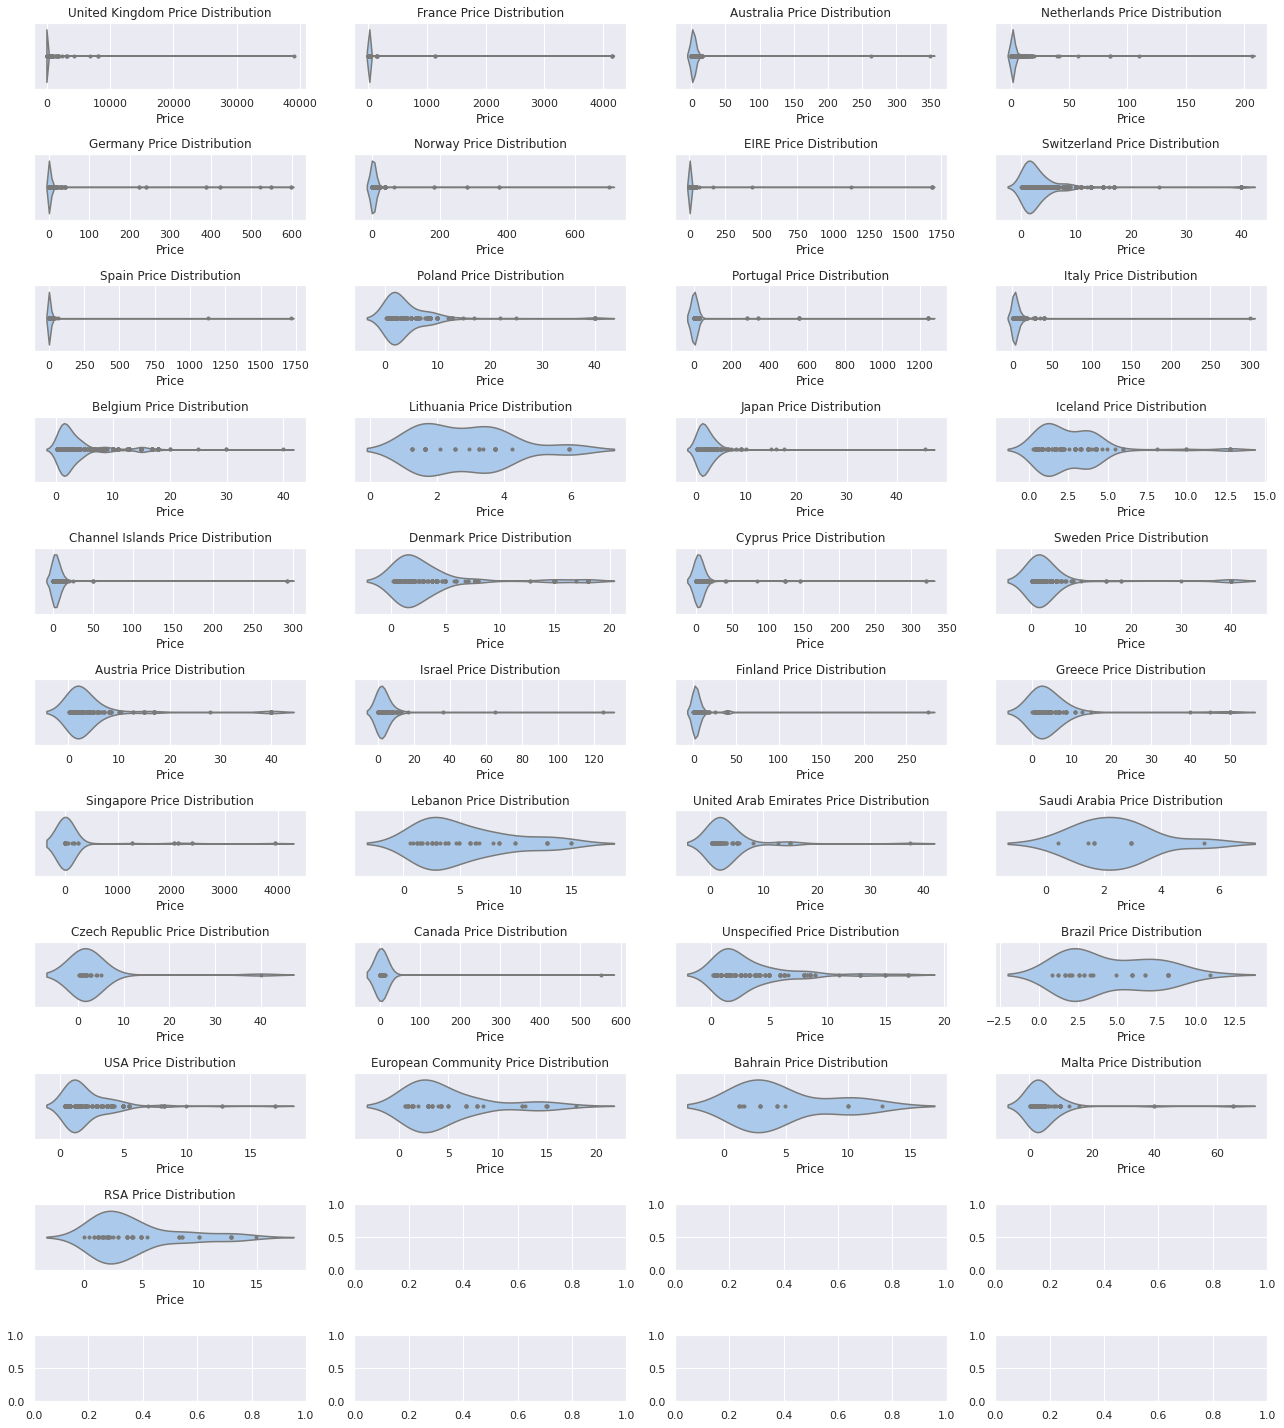

In [26]:
fig, ax = plt.subplots(11, 4, figsize=(18,20))
axes_ = [axes_row for axes in ax for axes_row in axes]

for i, c in enumerate(countries):
    sns.violinplot(x = "Price", data = data[data["Country"] == c], ax = axes_[i], inner = "point", palette = "pastel")
    axes_[i].set_title(c + ' ' + "Price Distribution")
    plt.tight_layout()

From the above plot what I can interpret is that most of the data is pretty skewed and there is lot's of high extreme values that are present in the data.

In [27]:
#Total Number of Unique Invoices 
len(data["Invoice"].unique())

22190

In [28]:
temp_invoice_df = data.groupby("Invoice").sum()

In [29]:
temp_invoice_df.reset_index(inplace = True)

In [30]:
#Below are the top 30 invoices with total quantity purchased by them
temp_invoice_df.sort_values(by = "Quantity", ascending = False).head(30).iloc[:,:2].style.background_gradient(cmap = "Blues")

,Invoice,Quantity
18503,581483,80995
1909,541431,74215
8112,556917,15049
10612,563076,14730
14371,572035,13392
12419,567423,12572
17360,578841,12540
6437,552883,12266
10843,563614,12196
10344,562439,11848


In [31]:
data.groupby(["Invoice"]).mean().head(15).iloc[:, [1]].sort_values("Price", ascending = False)

,Price
Invoice,
536374,10.950000
536369,5.950000
536367,4.853333
536368,4.775000
536365,3.910000
536373,3.319375
536375,3.319375
536376,3.000000
536370,2.764500


I have grouped the data by Invoice to see the average spend by Invoice Number. Here one thing interesting to see that the invoice with number 536374 & 536369 has outspent others. So to gain some better clarity, let's check these 2 invoices and get insights on how much quantity they have purchased so far.

In [32]:
data[(data["Invoice"] == 489444) | (data["Invoice"] == 489447)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country


As we can see above, These 2 invoices with invoice number 536369 and 536374 had only single transaction, that's why the average price was too high.

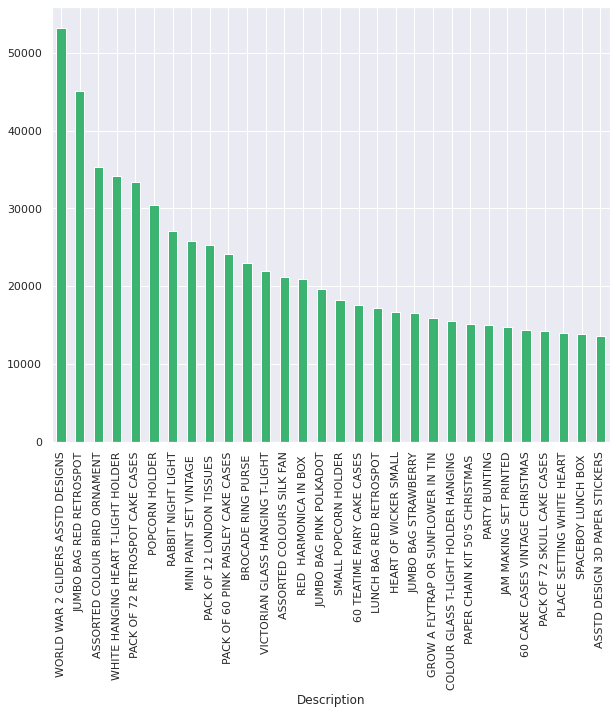

In [33]:
#Let's check which product has been purchased more often so far
plt.figure(figsize=(10,8))
data.groupby("Description").sum().sort_values(by = "Quantity", ascending = False).head(30)["Quantity"].plot(kind = "bar", color = 'mediumseagreen')

**Top 8 Countries With Most Transactions**

In [34]:
temp = data.groupby(["Country", "Description"]).sum()["Quantity"]

In [35]:
temp = pd.DataFrame(temp)

In [36]:
top_8_countries = ["United Kingdom", "Netherlands", "EIRE", "Denmark", "Germany", "France", "Australia", "Sweden"]

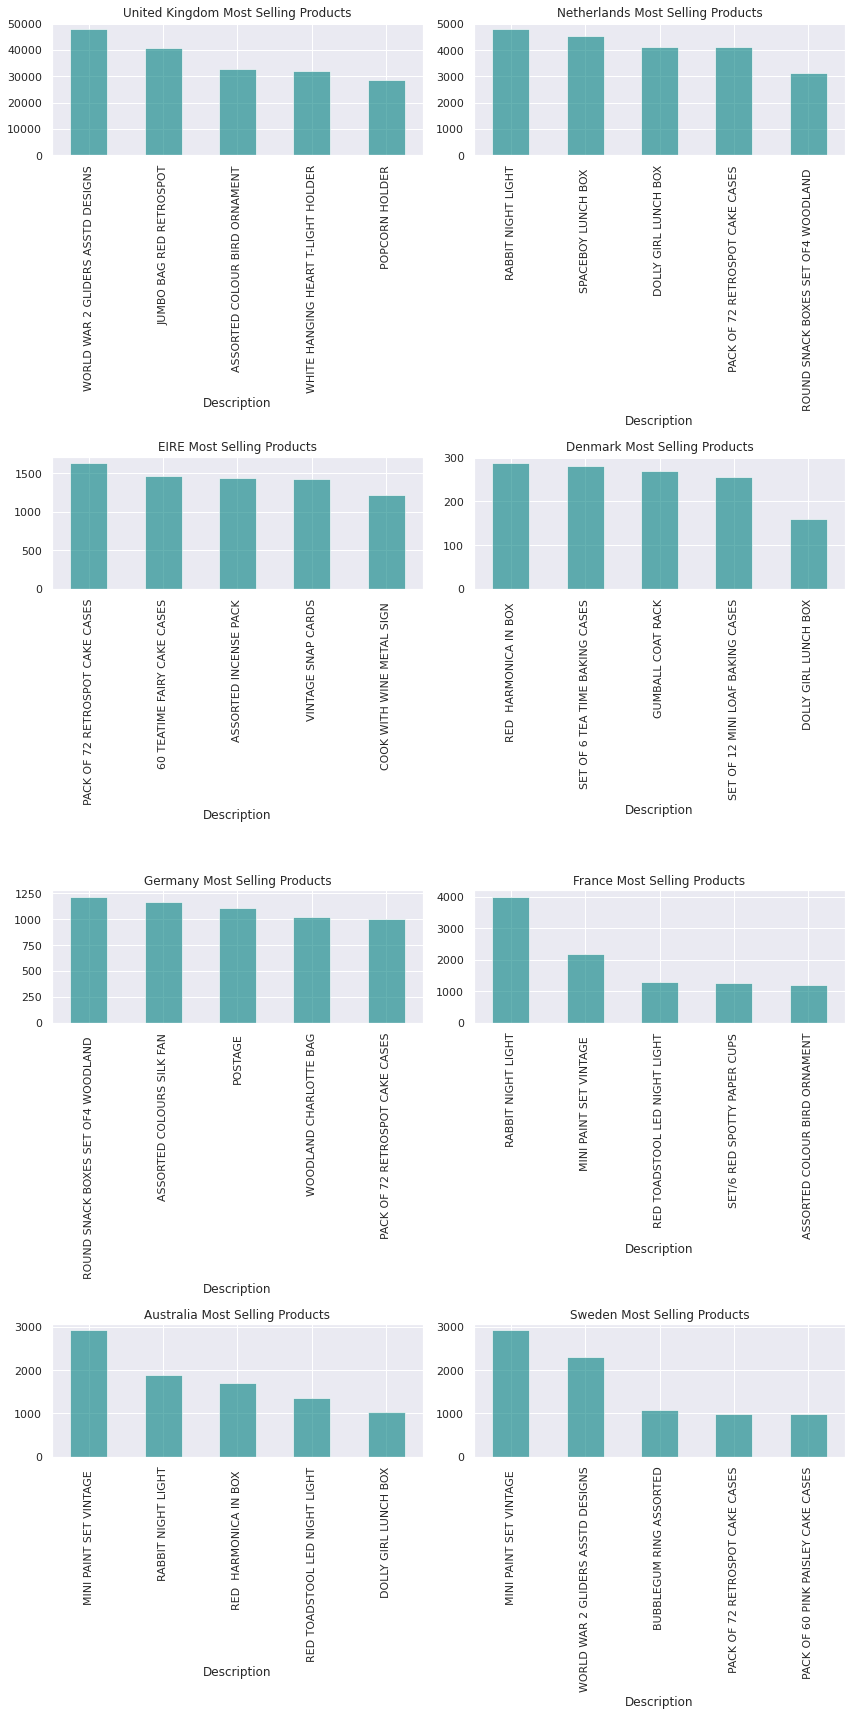

In [37]:
x = 1
plt.figure(figsize=(12,24))
for x, c in enumerate(top_8_countries):
    ax = plt.subplot(4,2, x+1)
    plt.title(c + ' '+ "Most Selling Products")
    temp.loc[c].sort_values(by = "Quantity", ascending = False)["Quantity"].head(5).plot(kind = "bar", ax = ax, color = "teal", alpha = 0.6)
    plt.tight_layout()

#### Filter required Columns
Here, we can filter the necessary columns for calculating CLTV. We only need here five columns CustomerID, InvoiceDate, InvoiceNo, Quantity, and UnitPrice.
 - CustomerID will uniquely define our customers.
 - InvoiceDate help us calculate numbers of days customer stayed with your product.
 - InvoiceNo helps us to count the number of time transaction performed(frequency).
 - Quantity is purchased item units in each transaction
 - UnitPrice of each unit purchased by the customer will help us to calculate the total purchased amount.

Here, we are going to perform the following operations:

Calculate the number of days between the present date and the date of last purchase from each customer.
Calculate the number of orders for each customer.
Calculate sum of purchase price for each customer.

In [38]:
# Preparing the Data 
data=data[~data["Invoice"].astype(str).str.contains("C",na=False)]
data=data[(data["Quantity"]>0)]
data.dropna(inplace=True)
data["TotalPrice"]=data["Quantity"]*data["Price"]

cltv_df= data.groupby("CustomerID").agg({'InvoiceDate': lambda date: (date.max()-date.min()).days,
                                        'Invoice': lambda num: len(num),
                                        'Quantity': lambda quant: quant.sum(),
                                        'TotalPrice': lambda price: price.sum()})
#Renaming the column
cltv_df.columns=['num_days','total_transaction','total_unit','total_price']
cltv_df.head()

,num_days,total_transaction,total_unit,total_price
CustomerID,,,,
12346.0,0,1,74215,77183.60
12347.0,365,182,2458,4310.00
12348.0,282,31,2341,1797.24
12349.0,0,73,631,1757.55
12350.0,0,17,197,334.40


## Calculate CLTV using following formula:
CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

In [39]:
# Average Order Value
cltv_df['avg_order_value']=cltv_df['total_price']/cltv_df['total_transaction']
cltv_df.head()

,num_days,total_transaction,total_unit,total_price,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12347.0,365,182,2458,4310.00,23.681319
12348.0,282,31,2341,1797.24,57.975484
12349.0,0,73,631,1757.55,24.076027
12350.0,0,17,197,334.40,19.670588


##  Calculate Purchase Frequency

In [40]:
##################################################
# 2. Calculate Purchase Frequency
##################################################

cltv_df.shape[0]
cltv_df["purchase_frequency"]=cltv_df["total_transaction"]/cltv_df.shape[0]
cltv_df["purchase_frequency"].head(10)

CustomerID
12346.0    0.000230
12347.0    0.041945
12348.0    0.007145
12349.0    0.016824
12350.0    0.003918
12352.0    0.019590
12353.0    0.000922
12354.0    0.013367
12355.0    0.002996
12356.0    0.013598
Name: purchase_frequency, dtype: float64

## Calculate Repeat Rate and Churn Rate

In [41]:
# repeat rate is the the number of customers who shopped at least 2 times in the dataset divided by the total number of customers
repeat_rate=cltv_df[cltv_df.total_transaction>1].shape[0]/cltv_df.shape[0]
#so the repeat_rate is 0.978442280945758
churn_rate = 1 - repeat_rate
churn_rate

0.016593685180917306

## Calculate Profit Margin
Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [42]:
# We assume 5% profit from the total price and since it is unique for each customer, 
# we add this dataset, profit margin to this dataset.
cltv_df["profit_margin"]=cltv_df["total_price"]*0.05
cltv_df["profit_margin"].head()

CustomerID
12346.0    3859.1800
12347.0     215.5000
12348.0      89.8620
12349.0      87.8775
12350.0      16.7200
Name: profit_margin, dtype: float64

## Calcualte Customer Lifetime Value

In [43]:
# CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
# Customer_Value = Average_Order_Value * Purchase_Frequency
cltv_df['CV']=(cltv_df['avg_order_value']/cltv_df['purchase_frequency'])/churn_rate
cltv_df['CLTV']=cltv_df['CV']*cltv_df["profit_margin"]

pd.set_option('display.float_format', lambda x: '%.5f' % x)
cltv_df.sort_values("CLTV",ascending=False).head()

,num_days,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV
CustomerID,,,,,,,,,
12346.00000,0,1,74215,77183.60000,77183.60000,0.00023,3859.18000,20182354717.99439,77887339680589.60938
16446.00000,204,3,80997,168472.50000,56157.50000,0.00069,8423.62500,4894781555.82175,41231804283158.96094
15098.00000,0,3,121,39916.50000,13305.50000,0.00069,1995.82500,1159729617.43287,2314617363712.95264
15749.00000,97,10,18028,44534.30000,4453.43000,0.00230,2226.71500,116450520.54032,259302120844.93677
15195.00000,0,1,1404,3861.00000,3861.00000,0.00023,193.05000,1009593638.62500,194902051936.55576


In [44]:
# to make more understandable and readable lets transform it

scaler=MinMaxScaler(feature_range=(1,100))
scaler.fit(cltv_df[["CLTV"]])
cltv_df["SCALED_CLTV"]=scaler.transform(cltv_df[["CLTV"]])
cltv_df.sort_values("CLTV",ascending=False)
pd.set_option('display.max_columns',20)
cltv_df[["total_transaction","total_unit","total_price","CLTV","SCALED_CLTV"]].sort_values(by="CLTV",ascending=False).head()

,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
CustomerID,,,,,
12346.00000,1,74215,77183.60000,77887339680589.60938,100.00000
16446.00000,3,80997,168472.50000,41231804283158.96094,53.40837
15098.00000,3,121,39916.50000,2314617363712.95264,3.94203
15749.00000,10,18028,44534.30000,259302120844.93677,1.32959
15195.00000,1,1404,3861.00000,194902051936.55576,1.24773


In [45]:
cltv_df.sort_values("total_price",ascending=False)
cltv_df["segment"]=pd.qcut(cltv_df["SCALED_CLTV"],4,labels=['D','C','B','A'])
cltv_df[["segment", "total_transaction", "total_unit", "total_price", "CLTV", "SCALED_CLTV"]].sort_values(
    by="SCALED_CLTV",
    ascending=False).head()

,segment,total_transaction,total_unit,total_price,CLTV,SCALED_CLTV
CustomerID,,,,,,
12346.00000,A,1,74215,77183.60000,77887339680589.60938,100.00000
16446.00000,A,3,80997,168472.50000,41231804283158.96094,53.40837
15098.00000,A,3,121,39916.50000,2314617363712.95264,3.94203
15749.00000,A,10,18028,44534.30000,259302120844.93677,1.32959
15195.00000,A,1,1404,3861.00000,194902051936.55576,1.24773


# Prediction Model for CLTV
Let's build the CLTV prediction model. 
Here, we are going to predict CLTV using Linear Regression Model.
Let's first use the data loaded and filtered above.

In [46]:
cltv_df.head()

,num_days,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV,SCALED_CLTV,segment
CustomerID,,,,,,,,,,,
12346.00000,0,1,74215,77183.60000,77183.60000,0.00023,3859.18000,20182354717.99439,77887339680589.60938,100.00000,A
12347.00000,365,182,2458,4310.00000,23.68132,0.04195,215.50000,34023.68101,7332103.25821,1.00001,B
12348.00000,282,31,2341,1797.24000,57.97548,0.00714,89.86200,489023.23243,43944605.71229,1.00006,A
12349.00000,0,73,631,1757.55000,24.07603,0.01682,87.87750,86240.00491,7578556.03140,1.00001,B
12350.00000,0,17,197,334.40000,19.67059,0.00392,16.72000,302562.59047,5058846.51258,1.00001,B


Extract month and year from InvoiceDate.

In [47]:
data['month_yr'] = data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice,month_yr
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55000,17850.00000,United Kingdom,15.30000,Dec-2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75000,17850.00000,United Kingdom,22.00000,Dec-2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010


The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [48]:
sale=data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPrice',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011
0,12346.00000,0.00000,0.00000,0.00000,0.00000,0.00000,77183.60000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,12347.00000,636.25000,584.91000,711.79000,224.82000,0.00000,475.39000,0.00000,382.52000,0.00000,0.00000,0.00000,1294.32000,0.00000
2,12348.00000,367.00000,0.00000,892.80000,0.00000,0.00000,227.44000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,310.00000
3,12349.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1757.55000,0.00000,0.00000
4,12350.00000,0.00000,0.00000,0.00000,0.00000,334.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


Let's sum all the months sales.

In [49]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.00000,0.00000,0.00000,0.00000,0.00000,0.00000,77183.60000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,77183.60000
1,12347.00000,636.25000,584.91000,711.79000,224.82000,0.00000,475.39000,0.00000,382.52000,0.00000,0.00000,0.00000,1294.32000,0.00000,3673.75000
2,12348.00000,367.00000,0.00000,892.80000,0.00000,0.00000,227.44000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,310.00000,1430.24000
3,12349.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1757.55000,0.00000,0.00000,1757.55000
4,12350.00000,0.00000,0.00000,0.00000,0.00000,334.40000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,334.40000


### Selecting Feature
Here, we need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables). Select latest 6 month as independent variable.

In [51]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

### Splitting Data
To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

We need to pass 3 parameters features, target, and test_set size. Additionally, we can use random_state as a seed value to maintain reproducibility, which means whenever we split the data will not affect the results. Also, if random_state is None, then random number generator uses np.random for selecting records randomly. It means if we don't set a seed, it is different each time.

In [52]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

In [53]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[148.55572905]
[[1.01043329 0.78681107 2.09831559 1.48800131 2.39298465 2.07180733]]


### Model Fit 
In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [54]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9795236197719982


This model has a higher R-squared (0.88). This model provides a better fit to the data.
Model Evaluation
For regression problems following evaluation metrics used:
- Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
- Mean Squared Error (MSE) is the mean of the squared errors.
- Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [55]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))

# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 592.7674514419834
MSE 1722448.1817482298
RMSE: 1312.4207335104966


RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

# Pros and Cons of CLTV
- CLTV helps us to design an effective business plan and also provide a chance to scale our business.
- CLTV draw meaningful customer segments these segment can help us to identify needs of the different-different segment. 
- CLTV can figure out most profitable customers, but how we are going to make a profit from them, it depends on our strategy. 
Generally, CLTV models are confused and misused. Obsession with CLTV may create blunders. Companies only focus on finding the best customer group and focusing on them and repeat the business, but it’s also important to give attention to other customers.

# CLTV Model Definition
For the CLTV models, the following nomenclature is used:
- Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases.
- T represents the age of the customer in whatever time units chosen (daily, in our dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

We have some cleaning to do, then create a new dataframe that contains CustomerID, InvoiceDate (remove the time) and add a new column — sales:

**RFM Estimation**

In [56]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
data = data[pd.notnull(data['CustomerID'])]
data = data[(data['Quantity']>0)]
data['Sales'] = data['Quantity'] * data['Price']
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,TotalPrice,month_yr,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55000,17850.00000,United Kingdom,15.30000,Dec-2010,15.30000
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010,20.34000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75000,17850.00000,United Kingdom,22.00000,Dec-2010,22.00000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010,20.34000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39000,17850.00000,United Kingdom,20.34000,Dec-2010,20.34000


In [57]:
rfm_summary  = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Sales")
rfm_summary = rfm_summary.reset_index() #resetting the index

In [58]:
rfm_summary.shape

(4339, 5)

In [59]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,0.00000,0.00000,325.00000,0.00000
1,12347.00000,6.00000,365.00000,367.00000,599.70167
2,12348.00000,3.00000,283.00000,358.00000,301.48000
3,12349.00000,0.00000,0.00000,18.00000,0.00000
4,12350.00000,0.00000,0.00000,310.00000,0.00000


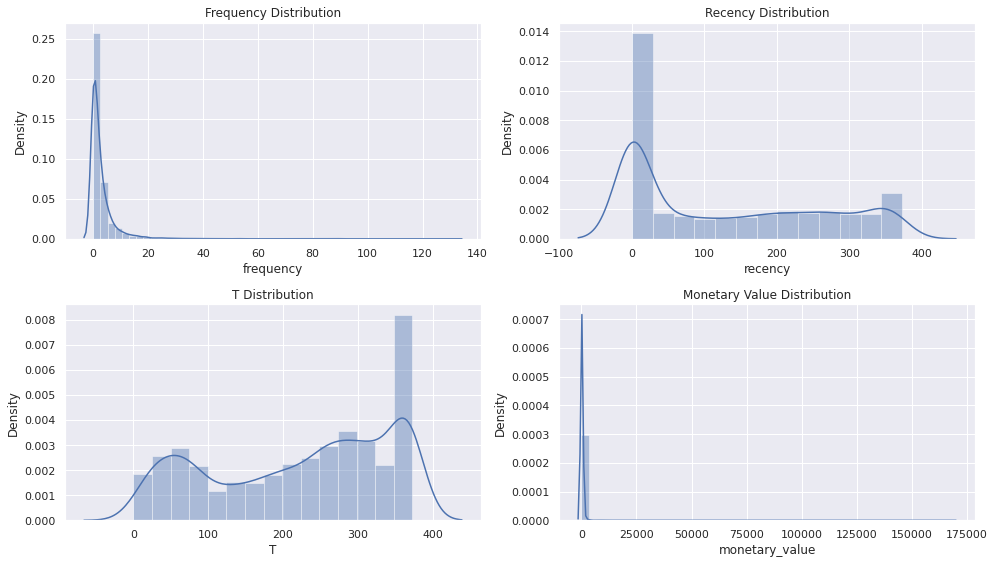

In [60]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

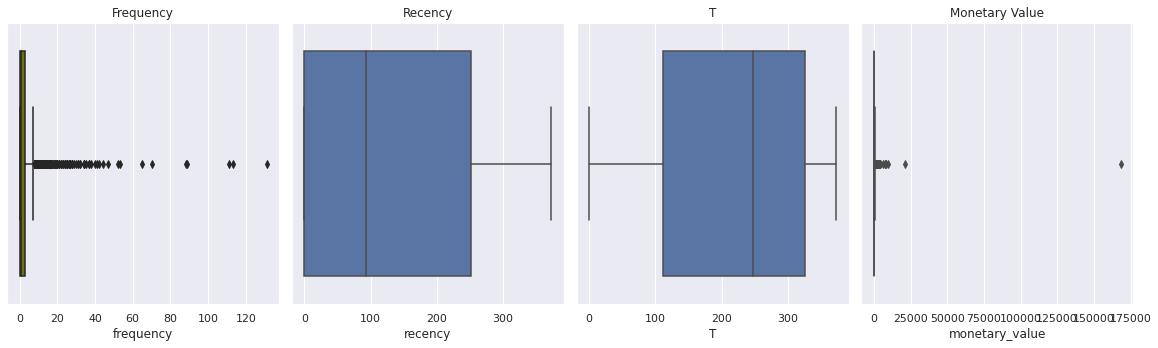

In [61]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "red")
plt.title("Monetary Value")
plt.tight_layout()

In [62]:
rfm_summary.describe()

,CustomerID,frequency,recency,T,monetary_value
count,4339.00000,4339.00000,4339.00000,4339.00000,4339.00000
mean,15299.93685,2.86402,130.74142,222.78290,306.94417
std,1721.88976,5.95274,132.21018,117.88362,2612.45338
min,12346.00000,0.00000,0.00000,0.00000,0.00000
25%,13812.50000,0.00000,0.00000,112.00000,0.00000
50%,15299.00000,1.00000,93.00000,248.00000,176.94000
75%,16778.50000,3.00000,252.00000,326.00000,360.16167
max,18287.00000,131.00000,373.00000,373.00000,168469.60000


In [63]:
#checking for the values containing zero.

print("Total Number of Frequency with 0: %s" % (len(rfm_summary[rfm_summary["frequency"] == 0])))
print("Total Number of Recency with 0: %s" % (len(rfm_summary[rfm_summary["recency"] == 0])))
print("Total Number of Monetary Value with 0: %s" % (len(rfm_summary[rfm_summary["monetary_value"] == 0])))

Total Number of Frequency with 0: 1549
Total Number of Recency with 0: 1549
Total Number of Monetary Value with 0: 1549


Now we have the data related to the RFM, we can now start with which model we can build to predict our customer's lifetime value. First we have to figure out either we have to do the prediction based on the customer level or the aggregate level.

For this analysis I am using to predict the customer lifetime value on the customer level rather than the aggregate or a cohort level.

Before building the model, we have to understand few of the most important things. We have to understand the business context that is the type of customers (contractual or non-contractual) and their purchase opportunity (discrete or continuous). The combination of both defines the business context which going to affect our CLV estimation approach.

Basic Terms:

a) Contractual Customers - Contractual customers are subscription based customers. They churned on a defined date if they choose not to renew the subscription.

b) Non-Contractual Customers - Non Contractual customers generally exist in e-commerce or retail business where there's no defined time period when the customer is going to churn.

c) Continuous Purchase - It refers to the time period when the customer purchase a certain thing in any time period. Ex- Retail & E-commerce.

d) Discrete Purchase - It refers to the time period when the customer purchase a certain thing on a specific time period. Ex - Netflix, Hulu, Hotstar Subscription.

For this analysis we are going to use the non-contractual with continuous purchase opportunity and the best fitted models we are going to use will be BG-NBD Model, Pareto-NBD Model, Modifies BG Model along with Gamma Gamma Distribution model for estimating the expected monetary value as a part of the customer lifetime value prediction.


# Beta Geo - Negative Binomial Distribution + Gamma Gamma Distribution Model **bold text**

In [64]:
summary_bgf = rfm_summary.copy()

In [65]:
summary_bgf.head(2)

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,0.00000,0.00000,325.00000,0.00000
1,12347.00000,6.00000,365.00000,367.00000,599.70167


There are 4339 customers under our analysis.
CustomerID 12346 made 1 purchase only (no repeat), so the frequency and recency are 0, and the age is 325 days (e.g. the duration between the first purchase and the end of the period in the analysis).

In [66]:
bgf = BetaGeoFitter(penalizer_coef = 0.1)

# We can use penalizer of 0.001 or 0.1 which we will be going to use later on based on the model performance and model selection

In [67]:
bgf.fit(summary_bgf["frequency"], summary_bgf["recency"], summary_bgf["T"])

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>

Among all customers in our data, more than 35% of them only made purchase once (no repeat).
## Frequency/Recency Analysis Using the BG/NBD Model

In [68]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.59356,0.01480,0.56455,0.62257
alpha,49.41461,1.63830,46.20353,52.62568
a,0.00000,0.00000,-0.00000,0.00000
b,0.00000,0.04711,-0.09234,0.09234


In [69]:
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>


### Visualizing our frequency/recency matrix
Let's do some hypothetical analysis-
- Customer who purchased every day for four weeks straight, and no transactions in months; chances of that customer being alive is less. 
- On the other hand, a customer who historically made purchase once a quarter, and again last quarter, is likely still alive. We can visualize this relationship using the frequency/recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given the recency (age at last purchase) and frequency (the number of repeat transactions  made).

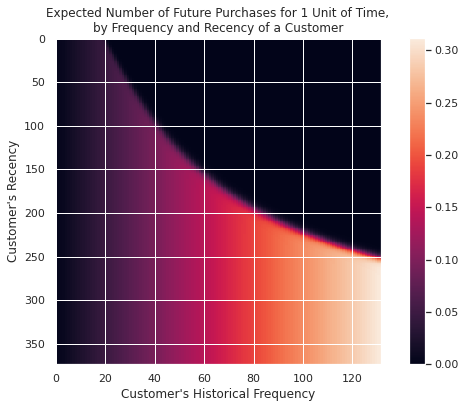

In [70]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(bgf)
plt.show()

We can see that, if a customer has made 120 purchases, and their latest purchase was when they were approximately 350 days old (i.e. Recency: the duration between their first transaction and their latest transaction is 350 days), then they are our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.

Customers who have purchased a lot but not recently (top-right corner), have probably gone.
There are also another type of customers that around (40, 100) that represents the customer who buys infrequently, and we have not seen them recently, so they might buy again. However, we are not sure if they have gone or just between purchases.

Another interesting matrix to look at is the probability of still being alive:


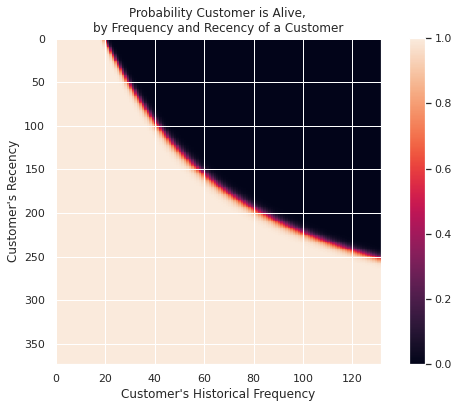

In [71]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,6))
plot_probability_alive_matrix(bgf)
plt.show()

Customers who have purchased recently are almost surely “alive”.
Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

**Ranking customers from best to worst**

Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [72]:
t = 30
summary_bgf['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_bgf['frequency'], summary_bgf['recency'], summary_bgf['T'])
summary_bgf.sort_values(by='predicted_purchases').tail(10)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
2991,16422.00000,47.00000,352.00000,369.00000,702.47234,3.41242
1070,13798.00000,52.00000,371.00000,372.00000,706.65096,3.74407
1603,14527.00000,53.00000,367.00000,369.00000,155.01642,3.84262
562,13089.00000,65.00000,367.00000,369.00000,893.71431,4.70301
481,12971.00000,70.00000,369.00000,372.00000,159.21129,5.02547
1662,14606.00000,88.00000,372.00000,373.00000,135.89011,6.29194
2177,15311.00000,89.00000,373.00000,373.00000,677.72944,6.36296
4011,17841.00000,111.00000,372.00000,373.00000,364.45216,7.92540
326,12748.00000,113.00000,373.00000,373.00000,298.36088,8.06745
1880,14911.00000,131.00000,372.00000,373.00000,1093.66168,9.34581


Listed above are our top 10 customers that the model expects them to make purchases in the next day. We can see that the customer who has made 131 purchases, and bought very recently from us, is probably going to buy again in the next period.


The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.
#### Assessing model fit
So far, we can predict and we can visualize our customers’ behavior. Now let us assess the model’s correctness. The ﬁrst is to compare your data versus artiﬁcial data simulated with our ﬁtted model’s parameters.


CPU times: user 606 ms, sys: 4.03 ms, total: 610 ms
Wall time: 608 ms


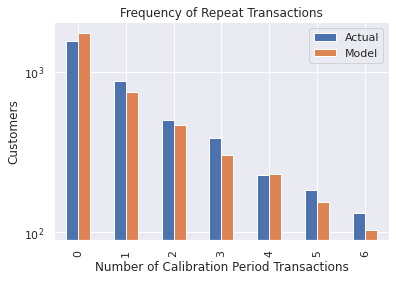

In [73]:
%%time 

from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(bgf, max_frequency=7)
ax.set_yscale('log')
sns.despine();

We can see that our actual data and our simulated data line up well. 
So, we can continue on with our analysis. We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

### Example using transactional datasets
Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [74]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_history_alive
transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [76]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [77]:
bgf.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.BetaGeoFitter: fitted with 2787 subjects, a: 0.00, alpha: 41.27, b: 0.00, r: 0.50>

### More model fitting
With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think cross-validation in standard machine learning literature).

In [78]:
summary_cal_holdout

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,0.00000,0.00000,141.00000,0.00000,184.00000
12347.00000,2.00000,121.00000,183.00000,4.00000,184.00000
12348.00000,2.00000,110.00000,174.00000,1.00000,184.00000
12350.00000,0.00000,0.00000,126.00000,0.00000,184.00000
12352.00000,3.00000,34.00000,112.00000,3.00000,184.00000
...,...,...,...,...,...
18272.00000,1.00000,21.00000,62.00000,4.00000,184.00000
18273.00000,0.00000,0.00000,73.00000,2.00000,184.00000
18280.00000,0.00000,0.00000,93.00000,0.00000,184.00000


With this dataset, we can perform ﬁtting on the _cal columns, and test on the _holdout columns:


CPU times: user 59.3 ms, sys: 1.02 ms, total: 60.3 ms
Wall time: 59.4 ms


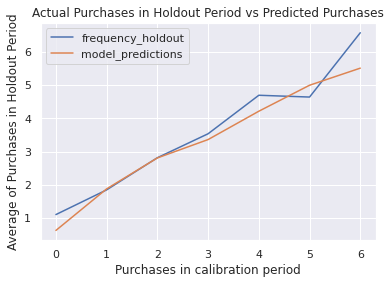

In [79]:
%%time 

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [80]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,0.00000,0.00000,141.00000,0.00000,184.00000
12347.00000,2.00000,121.00000,183.00000,4.00000,184.00000
12348.00000,2.00000,110.00000,174.00000,1.00000,184.00000
12350.00000,0.00000,0.00000,126.00000,0.00000,184.00000
12352.00000,3.00000,34.00000,112.00000,3.00000,184.00000


In [81]:
#Creating a function which can predict the future purchased value based on the lookup window

def bgf_get_pred_error(t, id_):
    
    individual = summary_bgf[summary_bgf["CustomerID"] == id_]
    
    ind_pred = bgf.predict(t, individual["frequency"], individual["recency"], individual["T"])
    
    actual_val = individual["frequency"]/individual["recency"]*t
    
    error = actual_val - ind_pred
    
    print("Your Predicted Purchase: %s" % (ind_pred))
    print("Your Actual Purchase: %s" % (actual_val))
    print("Prediction Error: %s" % (error))

In [82]:
bgf_get_pred_error(15, 12348.0)

Your Predicted Purchase: 2   0.13162
dtype: float64
Your Actual Purchase: 2   0.15901
dtype: float64
Prediction Error: 2   0.02739
dtype: float64


In [83]:
id_1 = 14606.0
id_2 = 12352.0

In [84]:
days_since_birth = 365

In [85]:
sp_trans_1 = data[data["CustomerID"] == id_1]
sp_trans_2 = data[data["CustomerID"] == id_2]

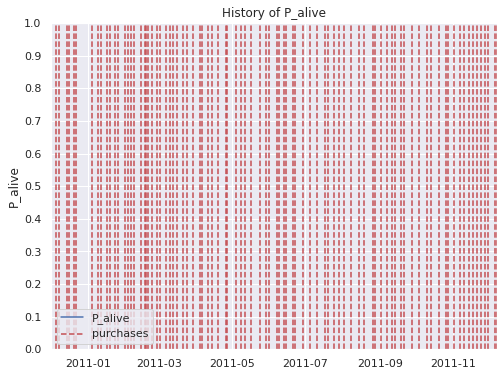

In [86]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_1, "InvoiceDate")

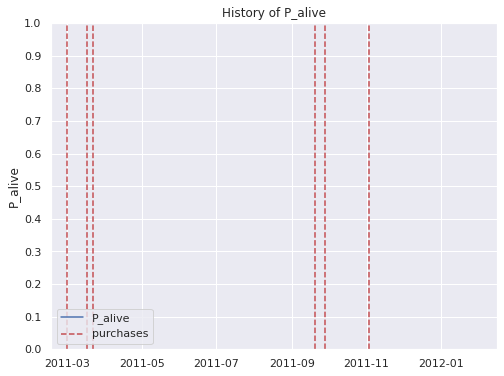

In [87]:
plt.figure(figsize=(8,6))
plot_history_alive(bgf, days_since_birth, sp_trans_2, "InvoiceDate")

In [88]:
summary_bgf["actual_30"] = summary_bgf["frequency"]/summary_bgf["recency"]*30

In [89]:
summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.04756,NaN
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47502,0.49315
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26461,0.31802
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.26414,NaN
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.04954,NaN


In [90]:
summary_bgf = summary_bgf.fillna(value = 0) #filling null values with 0

In [91]:
#calculating the prediction error for the 30 days purchase prediction
summary_bgf["Error"] = summary_bgf["actual_30"] - summary_bgf["predicted_purchases"]

In [92]:
mse = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])

In [93]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_bgf["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 2.6720506347704607
Average Error:  0.22114720578978245
Root Mean Squared Error: 1.6346408274512358


In [94]:
#Purchase Prediction

bgf_mse_purchase_30 = mean_squared_error(summary_bgf["actual_30"],summary_bgf["predicted_purchases"])
bgf_rmse_purchase_30 = sqrt(bgf_mse_purchase_30)
bgf_avg_error_purchase_30 = summary_bgf["Error"].mean()

In [95]:
summary_bgf.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.04756,0.00000,-0.04756
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47502,0.49315,0.01813
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26461,0.31802,0.05341
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.26414,0.00000,-0.26414
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.04954,0.00000,-0.04954


In [96]:
#Filtering the data where we have the values of 0 or less than 0.
res_summary = summary_bgf[summary_bgf["frequency"] > 0]

In [97]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

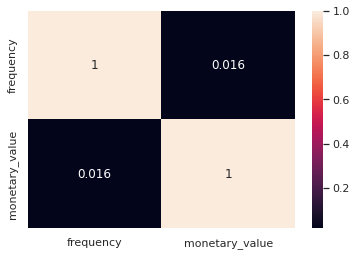

In [98]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

To proceed with the Gamma Gamma Model we have to check for the assumption whether the frequency and monetary values are intercorrelated or not. As we can see here, the correlation between the frequency and monetary value is pretty low so we can go ahead to build Gamma Gamma Model

In [99]:
ggf_gamma = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [100]:
ggf_gamma.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [101]:
ggf_gamma.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.10352,0.11200,1.88401,2.32304
q,3.44991,0.13904,3.17739,3.72243
v,485.57094,42.59555,402.08365,569.05823


In [102]:
summary_bgf.head(2)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.04756,0.00000,-0.04756
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47502,0.49315,0.01813


In [103]:
summary_ = summary_bgf[(summary_bgf["monetary_value"] > 0) & (summary_bgf["frequency"] > 0)]

In [104]:
summary_.shape

(2790, 8)

In [105]:
summary_["Expected_Avg_Sales"] = ggf_gamma.conditional_expected_average_profit(summary_["frequency"], 
                                                                        summary_["monetary_value"])

In [106]:
summary_.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47502,0.49315,0.01813,569.98881
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26461,0.31802,0.05341,333.76267
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57266,0.69231,0.11964,376.16686
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20781,0.19802,-0.00979,324.00894
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23974,0.20134,-0.03839,539.93064


In [107]:
print("Expected Average Sales: %s" % summary_["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_["monetary_value"].mean())
print("Difference: %s" % (summary_["monetary_value"].mean() - summary_["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_["monetary_value"], summary_["Expected_Avg_Sales"])))

Expected Average Sales: 454.570134532911
Actual Average Sales: 477.3586892535673
Difference: 22.788554720656293
Mean Squared Error: 3000567.2299019275
Root Mean Squared Error: 1732.2145449977977


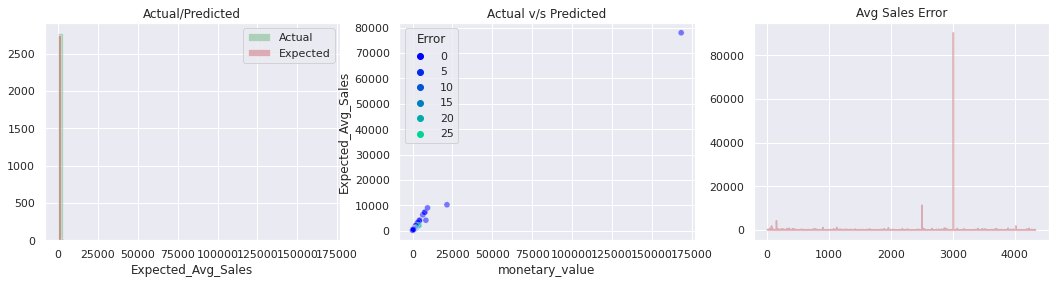

In [108]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_["monetary_value"], color = "g", kde = False)
sns.distplot(summary_["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(summary_["monetary_value"], summary_["Expected_Avg_Sales"], alpha = 0.5, hue = summary_["Error"], palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_["monetary_value"]-summary_["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

In [109]:
summary_["predicted_clv"] = ggf_gamma.customer_lifetime_value(bgf,
                                                       summary_["frequency"],
                                                       summary_["recency"],
                                                       summary_["T"],
                                                       summary_["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [110]:
summary_.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47502,0.49315,0.01813,569.98881,7029.69189
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26461,0.31802,0.05341,333.76267,2267.48334
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57266,0.69231,0.11964,376.16686,5615.90837
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20781,0.19802,-0.00979,324.00894,1714.64645
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23974,0.20134,-0.03839,539.93064,3285.98824


In [111]:
#adding a 5% of profit margin
summary_["CLV"] = summary_["predicted_clv"]*0.05

In [112]:
summary_[summary_["CustomerID"] == 13902.0]

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV


In [113]:
summary_.sort_values(by = "Error", ascending = False)

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
4017,17850.00000,1.00000,1.00000,373.00000,3891.87000,0.11318,30.00000,29.88682,2022.22217,5682.26615,284.11331
2116,15230.00000,1.00000,1.00000,240.00000,59.40000,0.16518,30.00000,29.83482,251.75721,1041.91949,52.09597
4127,17991.00000,1.00000,1.00000,226.00000,87.45000,0.17358,30.00000,29.82642,264.71531,1152.93394,57.64670
2466,15700.00000,1.00000,1.00000,173.00000,3.90000,0.21494,30.00000,29.78506,226.11818,1228.42673,61.42134
3685,17391.00000,1.00000,1.00000,164.00000,101.76000,0.22401,30.00000,29.77599,271.32602,1538.65416,76.93271
...,...,...,...,...,...,...,...,...,...,...,...
3147,16642.00000,1.00000,203.00000,207.00000,380.60000,0.18644,0.14778,-0.03866,400.14020,1876.13198,93.80660
3367,16933.00000,1.00000,238.00000,239.00000,338.50000,0.16576,0.12605,-0.03971,380.69149,1581.14691,79.05735
3720,17436.00000,1.00000,225.00000,226.00000,93.90000,0.17358,0.13333,-0.04025,267.69498,1165.91155,58.29558
794,13404.00000,1.00000,211.00000,212.00000,34.68000,0.18288,0.14218,-0.04070,240.33745,1104.62071,55.23104


In [114]:
actual = summary_["monetary_value"]*summary_["actual_30"]

In [115]:
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]

In [116]:
error = actual - pred

In [117]:
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [118]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result["Actual"], result["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 186.56437788924083
Mean Squared Error: 7173693.151422975
Root Mean Squared Error: 2678.3750953559465


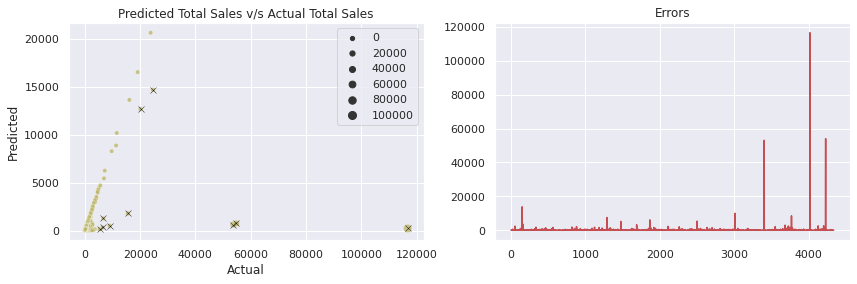

In [119]:
#Predicted v/s Actual
plt.figure(figsize=(14,4))
plt.subplot(121)
sns.scatterplot(result["Actual"], result["Predicted"], size = result["Error"], color = "darkkhaki", alpha = 0.8, marker = 'o')
sns.scatterplot((result[result["Error"] > 5000]["Actual"]), (result[result["Error"] > 5000]["Predicted"]), color = "k", marker = "x")
plt.title("Predicted Total Sales v/s Actual Total Sales")
plt.subplot(122)
plt.plot(result["Error"], color = "r")
plt.title("Errors")
plt.show()

In [120]:
#exporting the result to csv
summary_.to_csv("customer_lifetime_value_prediction.csv")

## Saving and loading model
When we have  lots of data and training takes a lot of time option with saving and loading model could be useful. First we need to ﬁt the model, then save it and load.

### Fit model



In [121]:
###from lifetimes import BetaGeoFitter 
#from lifetimes.datasets import load_cdnow_summary
#data = load_cdnow_summary(index_col=[0]) 
#bgf = BetaGeoFitter() 
#bgf.fit(summary['frequency'], summary['recency'], summary['T']) 
#bgf 

### Saving model
Model will be saved with dill to pickle object. Optional parameters save_data and save_generate_data_method are present to reduce ﬁnal pickle object size for big dataframes. Optional parameters: 
- save_data is used for saving data from model or not (default: True). 
- save_generate_data_method is used for saving generate_new_data method from model or not (default: True)


In [122]:
#bgf.save_model('bgf.pkl')


### Loading model
Before loading we should initialize the model ﬁrst and then use method load_model


In [123]:
#bgf_loaded = BetaGeoFitter() 
#bgf_loaded.load_model('bgf.pkl') 
#bgf_loaded 

In [124]:
#ggf.save_model('ggf.pkl')

In [125]:
#ggf_loaded = GammaGammaFitter() 
#ggf_loaded.load_model('ggf.pkl') 
#ggf_loaded 

# **PARETO/NBD MODEL + Gamma Gamma Distribution Model**

In [126]:
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt

In [127]:
#summary_pnbd = rfm_summary.copy()

In [128]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.691734078463378
Predicted Purchase R2 Score: 0.0868037295968912
Predicted Purchase Root Mean Squared Error: 1.6406505046667854
Predicted Purchase Average Purchases Error: 0.22002282066014175


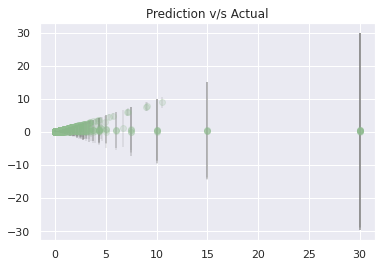

In [129]:
get_model(rfm_summary, 0.001, 30)

In [130]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [131]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 4339 subjects, alpha: 69.10, beta: 2242.60, r: 0.83, s: 0.00>

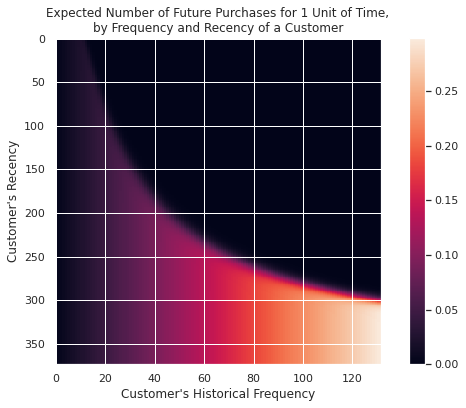

In [132]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

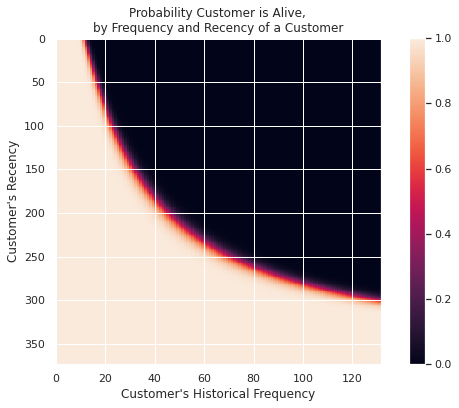

In [133]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [134]:
pareto_result = rfm_summary.copy()

In [135]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [136]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.00000,1.00000
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.00000,1.00000
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.00000,1.00000
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.00000,1.00000
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.00000,1.00000


In [137]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"],pareto_result["T"])
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.00000,1.00000,0.06303
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.00000,1.00000,0.46970
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.00000,1.00000,0.26888
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.00000,1.00000,0.28517
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.00000,1.00000,0.06552
...,...,...,...,...,...,...,...,...
4334,18280.00000,0.00000,0.00000,277.00000,0.00000,0.00000,1.00000,0.07177
4335,18281.00000,0.00000,0.00000,180.00000,0.00000,0.00000,1.00000,0.09971
4336,18282.00000,1.00000,119.00000,126.00000,77.84000,0.00000,1.00000,0.28108
4337,18283.00000,13.00000,334.00000,337.00000,152.80231,0.00000,1.00000,1.02151


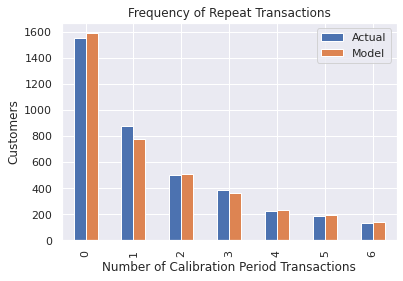

In [138]:
plot_period_transactions(pareto_model)

In [140]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                  calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [141]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,0.00000,0.00000,141.00000,0.00000,184.00000
12347.00000,2.00000,121.00000,183.00000,4.00000,184.00000
12348.00000,2.00000,110.00000,174.00000,1.00000,184.00000
12350.00000,0.00000,0.00000,126.00000,0.00000,184.00000
12352.00000,3.00000,34.00000,112.00000,3.00000,184.00000


In [142]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 2787 subjects, alpha: 61.94, beta: 929.69, r: 0.74, s: 0.00>

In [143]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

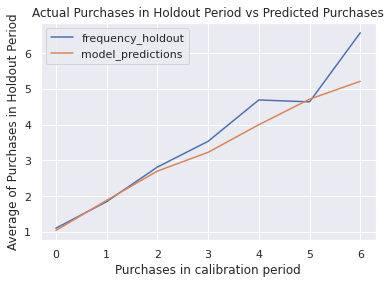

In [144]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [145]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346.00000,0.00000,0.00000,141.00000,0.00000,184.00000
12347.00000,2.00000,121.00000,183.00000,4.00000,184.00000
12348.00000,2.00000,110.00000,174.00000,1.00000,184.00000
12350.00000,0.00000,0.00000,126.00000,0.00000,184.00000
12352.00000,3.00000,34.00000,112.00000,3.00000,184.00000


In [146]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [147]:
pareto_result["actual30"].fillna(0, inplace = True)

In [148]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.00000,1.00000,0.06303,0.00000,-0.06303
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.00000,1.00000,0.46970,0.49315,0.02345
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.00000,1.00000,0.26888,0.31802,0.04914
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.00000,1.00000,0.28517,0.00000,-0.28517
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.00000,1.00000,0.06552,0.00000,-0.06552


In [149]:
print("Mean Squared Error: %s" % mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"])))
print("Average Purchase Error: %s" %(pareto_result["error"].mean()))

Mean Squared Error: 2.691735895769556
Root Mean Squared Error: 1.6406510585037746
Average Purchase Error: 0.21998626104797242


In [150]:
pareto_mse_purchase = mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"])
pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["actual30"], pareto_result["predicted_purchases"]))
pareto_avg_error_purchase = pareto_result["error"].mean()

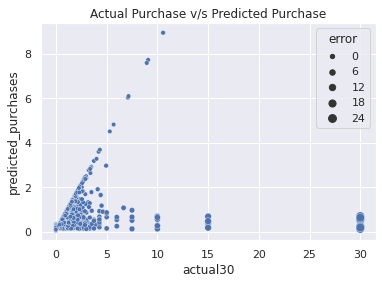

In [151]:
sns.scatterplot(pareto_result["actual30"], pareto_result["predicted_purchases"], size = pareto_result["error"])
plt.title("Actual Purchase v/s Predicted Purchase")
plt.show()

In [152]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

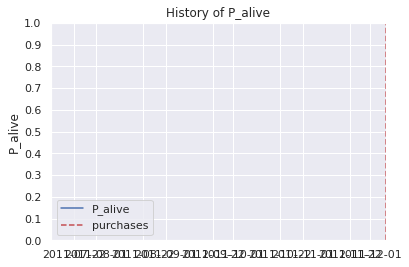

In [153]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [154]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [155]:
idx = idx.index

In [156]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [157]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [158]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [159]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

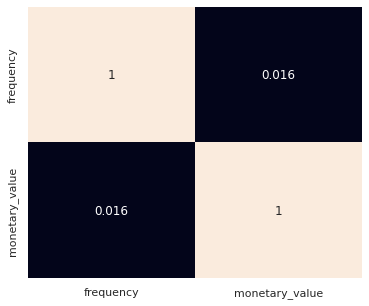

In [160]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [161]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [162]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 1.03, q: 0.18, v: 0.93>

In [163]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.03105,0.02986,0.97252,1.08958
q,0.17808,0.00365,0.17092,0.18524
v,0.92920,0.03121,0.86803,0.99037


In [164]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [165]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.00000,1.00000,0.46970,0.49315,0.02345,691.76534
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.00000,1.00000,0.26888,0.31802,0.04914,411.00228
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.00000,1.00000,0.56104,0.69231,0.13126,424.85880
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.00000,1.00000,0.21527,0.19802,-0.01725,449.55485
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.00000,1.00000,0.25029,0.20134,-0.04895,3372.87708


In [166]:
avg_purchase_error = ggf_filter["monetary_value"].mean() - ggf_filter["expected_avg_sales_"].mean()

In [167]:
print("Acutal Avg Sales: %s" % ggf_filter["monetary_value"].mean())
print("Predicted Avg Sales: %s" % ggf_filter["expected_avg_sales_"].mean())
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("Avg Sales Error: %s" % avg_purchase_error)
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Acutal Avg Sales: 477.3586892535673
Predicted Avg Sales: 1268.1006780910438
Mean Squared Error: 161327449.37478012
Root Mean Squared Error: 12701.4742992607
Avg Sales Error: -790.7419888374766
R2 Score: -14.320324163132883


In [168]:
actual = ggf_filter["actual30"] * ggf_filter["monetary_value"]
predicted = ggf_filter["predicted_purchases"] * ggf_filter["expected_avg_sales_"]

In [169]:
error = actual-predicted

In [170]:
result_p = pd.DataFrame([actual, predicted, error], index = ["Actual", "Predicted", "Error"]).T

In [171]:
print("Average Error: %s" % result_p["Error"].mean())
print("Mean Squared Error: %s" % mean_squared_error(result_p["Actual"], result_p["Predicted"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result_p["Actual"], result_p["Predicted"])))

Average Error: -6.129675763466625
Mean Squared Error: 13756516.210308135
Root Mean Squared Error: 3708.9777850922933


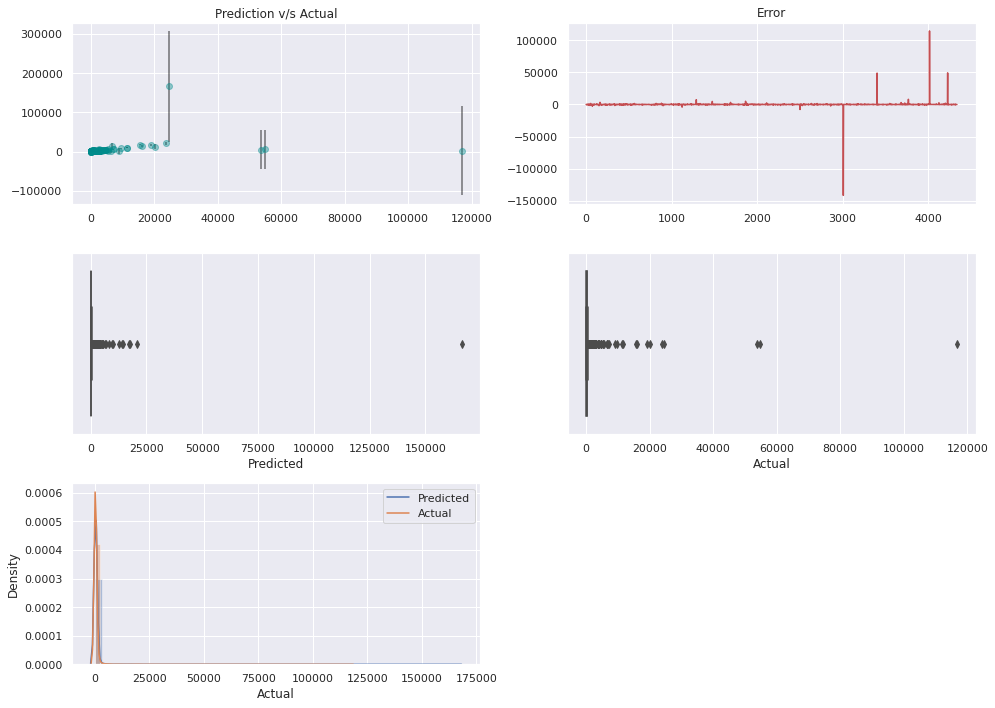

In [172]:
plt.figure(figsize=(14,10))
plt.subplot(321)
plt.errorbar(result_p["Actual"], result_p["Predicted"], yerr=result_p["Error"], fmt='o', color='darkcyan',
             ecolor='black', elinewidth=2, capsize=0, alpha = 0.4);
plt.title("Prediction v/s Actual")
plt.subplot(322)
plt.plot(result_p["Error"], color = 'r')
plt.title("Error")
plt.subplot(323)
sns.boxplot(result_p["Predicted"])
plt.subplot(324)
sns.boxplot(result_p["Actual"])
plt.subplot(325)
sns.distplot(result_p["Predicted"])
sns.distplot(result_p["Actual"])
plt.legend(["Predicted", "Actual"])
plt.tight_layout()

In [173]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [174]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
3009,16446.00000,4203671.96721
1690,14646.00000,540056.92873
152,12536.00000,458383.00280
4202,18102.00000,448774.38636
3729,17450.00000,368763.48908


In [175]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [176]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

# **Modified Beta Geom + Gamma Gamma Distribution Model**

In [177]:
summary_mbg = rfm_summary.copy()

In [178]:
summary_mbg.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346.00000,0.00000,0.00000,325.00000,0.00000
1,12347.00000,6.00000,365.00000,367.00000,599.70167
2,12348.00000,3.00000,283.00000,358.00000,301.48000
3,12349.00000,0.00000,0.00000,18.00000,0.00000
4,12350.00000,0.00000,0.00000,310.00000,0.00000


In [179]:
mbg = ModifiedBetaGeoFitter(penalizer_coef = 0.1)
mbg.fit(summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 49.41, b: 0.00, r: 0.59>

In [180]:
mbg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.59356,0.01480,0.56455,0.62257
alpha,49.41463,1.63830,46.20355,52.62570
a,0.00000,0.00000,-0.00000,0.00000
b,0.00000,0.02400,-0.04705,0.04705


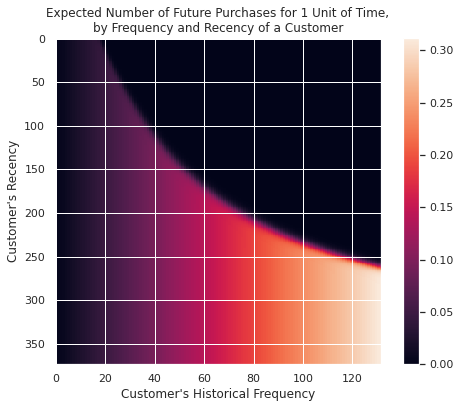

In [181]:
plt.figure(figsize=(8,6))
plot_frequency_recency_matrix(mbg)

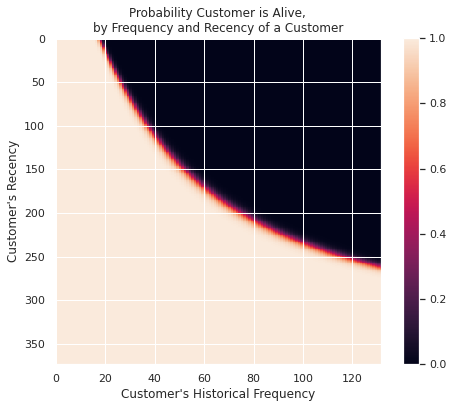

In [182]:
plt.figure(figsize=(8,6))
plot_probability_alive_matrix(mbg)

In [183]:
t = 30
summary_mbg["predicted_purchases"] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary_mbg["frequency"], summary_mbg["recency"], summary_mbg["T"])

In [184]:
summary_mbg

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.04124
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.25485
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.04300
...,...,...,...,...,...,...
4334,18280.00000,0.00000,0.00000,277.00000,0.00000,0.04746
4335,18281.00000,0.00000,0.00000,180.00000,0.00000,0.06827
4336,18282.00000,1.00000,119.00000,126.00000,77.84000,0.26965
4337,18283.00000,13.00000,334.00000,337.00000,152.80231,1.07094


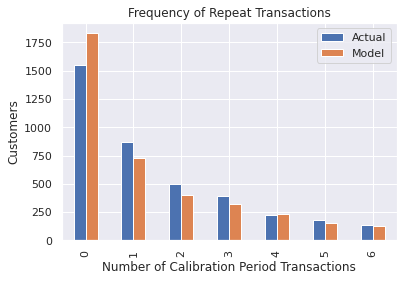

In [185]:
plot_period_transactions(mbg)

In [187]:
#dividing our dataset into training & holdout
summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2011-06-08',
                                                  observation_period_end = '2011-12-09')

In [188]:
mbg.fit(summary_cal_holdout["frequency_cal"],
       summary_cal_holdout["recency_cal"],
       summary_cal_holdout["T_cal"])

<lifetimes.ModifiedBetaGeoFitter: fitted with 2787 subjects, a: 0.00, alpha: 41.27, b: 0.00, r: 0.50>

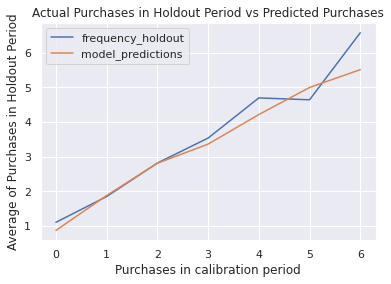

In [189]:
plot_calibration_purchases_vs_holdout_purchases(mbg, summary_cal_holdout)

In [190]:
summary_mbg["actual_30"] = summary_mbg["frequency"]/summary_mbg["recency"]*30

In [191]:
summary_mbg = summary_mbg.fillna(value = 0)

In [192]:
summary_mbg.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30
0,12346.00000,0.00000,0.00000,325.00000,0.00000,0.04124,0.00000
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788,0.49315
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324,0.31802
3,12349.00000,0.00000,0.00000,18.00000,0.00000,0.25485,0.00000
4,12350.00000,0.00000,0.00000,310.00000,0.00000,0.04300,0.00000


In [193]:
summary_mbg["Error"] = summary_mbg["actual_30"] - summary_mbg["predicted_purchases"]

In [194]:
mse = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])

In [195]:
print("Mean Squared Error: %s" % mse)
print("Average Error:  %s" % summary_mbg["Error"].mean())
print("Root Mean Squared Error: %s" % sqrt(mse))

Mean Squared Error: 2.661033018758465
Average Error:  0.22063745001393123
Root Mean Squared Error: 1.6312673045085115


In [196]:
mbg_mse_purchase = mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"])
mbg_rmse_purchase = sqrt(mean_squared_error(summary_mbg["actual_30"],summary_mbg["predicted_purchases"]))
mbg_avg_purchase_error = (summary_mbg["actual_30"].mean() - summary_mbg["predicted_purchases"].mean())

In [197]:
res_summary = summary_mbg[summary_mbg["frequency"] > 0]

In [198]:
final_summary = res_summary[res_summary["monetary_value"] > 0]

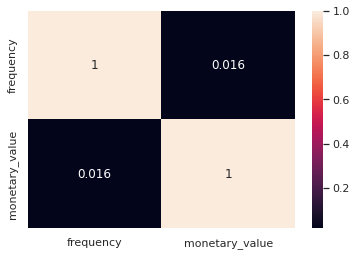

In [199]:
sns.heatmap(final_summary[["frequency", "monetary_value"]].corr(), annot = True)

In [200]:
ggf = lifetimes.GammaGammaFitter(penalizer_coef = 0.0)

In [201]:
ggf.fit(final_summary["frequency"], final_summary["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>

In [202]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,2.10352,0.11200,1.88401,2.32304
q,3.44991,0.13904,3.17739,3.72243
v,485.57094,42.59555,402.08365,569.05823


In [203]:
summary_mbg_new = summary_mbg[(summary_mbg["monetary_value"] > 0) & (summary_mbg["frequency"] > 0)]

In [204]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788,0.49315,0.01527
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324,0.31802,0.05478
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57848,0.69231,0.11383
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20505,0.19802,-0.00703
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23582,0.20134,-0.03448
...,...,...,...,...,...,...,...,...
4328,18272.00000,5.00000,244.00000,246.00000,487.75200,0.57474,0.61475,0.04002
4329,18273.00000,2.00000,255.00000,257.00000,76.50000,0.25180,0.23529,-0.01651
4336,18282.00000,1.00000,119.00000,126.00000,77.84000,0.26965,0.25210,-0.01755
4337,18283.00000,13.00000,334.00000,337.00000,152.80231,1.07094,1.16766,0.09673


In [205]:
summary_mbg_new["Expected_Avg_Sales"] = ggf.conditional_expected_average_profit(summary_mbg_new["frequency"], 
                                                                        summary_mbg_new["monetary_value"])

In [206]:
summary_mbg_new.head()

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788,0.49315,0.01527,569.98881
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324,0.31802,0.05478,333.76267
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57848,0.69231,0.11383,376.16686
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20505,0.19802,-0.00703,324.00894
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23582,0.20134,-0.03448,539.93064


In [207]:
print("Expected Average Sales: %s" % summary_mbg_new["Expected_Avg_Sales"].mean())
print("Actual Average Sales: %s" % summary_mbg_new["monetary_value"].mean())
print("Difference: %s" % (summary_mbg_new["monetary_value"].mean() - summary_mbg_new["Expected_Avg_Sales"].mean()))
print("Mean Squared Error: %s" % mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"]))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"])))

Expected Average Sales: 454.570134532911
Actual Average Sales: 477.3586892535673
Difference: 22.788554720656293
Mean Squared Error: 3000567.2299019275
Root Mean Squared Error: 1732.2145449977977


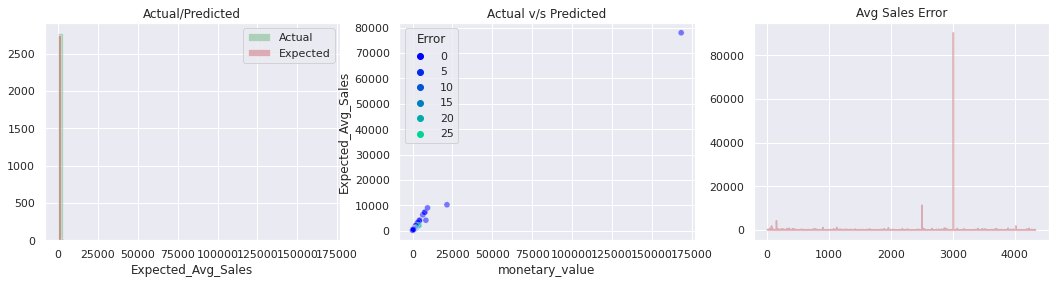

In [208]:
plt.figure(figsize=(18,4))
plt.subplot(131)
sns.distplot(summary_mbg_new["monetary_value"], color = "g", kde = False)
sns.distplot(summary_mbg_new["Expected_Avg_Sales"], color = "r", kde = False)
plt.title("Actual/Predicted")
plt.legend(["Actual", "Expected"])
plt.subplot(132)
sns.scatterplot(summary_mbg_new["monetary_value"], summary_mbg_new["Expected_Avg_Sales"], alpha = 0.5, hue = summary_["Error"], palette = "winter")
plt.title("Actual v/s Predicted")
plt.subplot(133)
plt.plot(summary_mbg_new["monetary_value"]-summary_mbg_new["Expected_Avg_Sales"], color = 'r', alpha = 0.4)
plt.title("Avg Sales Error")
plt.show()

In [209]:
summary_mbg_new["predicted_clv"] = ggf.customer_lifetime_value(mbg,
                                                       summary_mbg_new["frequency"],
                                                       summary_mbg_new["recency"],
                                                       summary_mbg_new["T"],
                                                       summary_mbg_new["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [210]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788,0.49315,0.01527,569.98881,7029.69187
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324,0.31802,0.05478,333.76267,2267.48330
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57848,0.69231,0.11383,376.16686,5615.90836
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20505,0.19802,-0.00703,324.00894,1714.64641
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23582,0.20134,-0.03448,539.93064,3285.98812
...,...,...,...,...,...,...,...,...,...,...
4328,18272.00000,5.00000,244.00000,246.00000,487.75200,0.57474,0.61475,0.04002,474.36952,7036.15525
4329,18273.00000,2.00000,255.00000,257.00000,76.50000,0.25180,0.23529,-0.01651,201.78129,1311.26349
4336,18282.00000,1.00000,119.00000,126.00000,77.84000,0.26965,0.25210,-0.01755,260.27583,1811.29967
4337,18283.00000,13.00000,334.00000,337.00000,152.80231,1.07094,1.16766,0.09673,174.51880,4823.43547


In [211]:
summary_mbg_new["CLV"] = summary_mbg_new["predicted_clv"]*0.05

In [212]:
actual = summary_["monetary_value"]*summary_["actual_30"]
pred = summary_["Expected_Avg_Sales"]*summary_["predicted_purchases"]
error = actual - pred
result = pd.DataFrame([actual, pred, error], index = ["Actual", "Predicted", "Error"]).T

In [213]:
print("Average Error: %s" % result["Error"].mean())
print("Mean Squared Error: %s" % (mean_squared_error(result["Actual"], result["Predicted"])))
print("Root Mean Squared Error: %s" % sqrt(mean_squared_error(result["Actual"], result["Predicted"])))

Average Error: 186.56437788924083
Mean Squared Error: 7173693.151422975
Root Mean Squared Error: 2678.3750953559465


In [214]:
summary_mbg_new

,CustomerID,frequency,recency,T,monetary_value,predicted_purchases,actual_30,Error,Expected_Avg_Sales,predicted_clv,CLV
1,12347.00000,6.00000,365.00000,367.00000,599.70167,0.47788,0.49315,0.01527,569.98881,7029.69187,351.48459
2,12348.00000,3.00000,283.00000,358.00000,301.48000,0.26324,0.31802,0.05478,333.76267,2267.48330,113.37417
5,12352.00000,6.00000,260.00000,296.00000,368.25667,0.57848,0.69231,0.11383,376.16686,5615.90836,280.79542
9,12356.00000,2.00000,303.00000,325.00000,269.90500,0.20505,0.19802,-0.00703,324.00894,1714.64641,85.73232
11,12358.00000,1.00000,149.00000,150.00000,683.20000,0.23582,0.20134,-0.03448,539.93064,3285.98812,164.29941
...,...,...,...,...,...,...,...,...,...,...,...
4328,18272.00000,5.00000,244.00000,246.00000,487.75200,0.57474,0.61475,0.04002,474.36952,7036.15525,351.80776
4329,18273.00000,2.00000,255.00000,257.00000,76.50000,0.25180,0.23529,-0.01651,201.78129,1311.26349,65.56317
4336,18282.00000,1.00000,119.00000,126.00000,77.84000,0.26965,0.25210,-0.01755,260.27583,1811.29967,90.56498
4337,18283.00000,13.00000,334.00000,337.00000,152.80231,1.07094,1.16766,0.09673,174.51880,4823.43547,241.17177


In [221]:
predicted_clv_results = pd.DataFrame(summary_mbg_new[["CustomerID", "predicted_clv"]])

In [226]:
predicted_clv_results = predicted_clv_results.merge(summary_mbg_new[["CustomerID", "predicted_clv"]], on = "CustomerID")

In [227]:
predicted_clv_results.columns = ["CustomerID", "BG-NBD", "Pareto-NBD", "MBG-NBD"]

In [228]:
predicted_clv_results.head(5)

,CustomerID,BG-NBD,Pareto-NBD,MBG-NBD
0,12347.00000,7029.69187,7029.69187,7029.69187
1,12348.00000,2267.48330,2267.48330,2267.48330
2,12352.00000,5615.90836,5615.90836,5615.90836
3,12356.00000,1714.64641,1714.64641,1714.64641
4,12358.00000,3285.98812,3285.98812,3285.98812


Purchase Prediction Result Summary

In [229]:
indexes = ["MSE Purchase Error", "RMSE Purchase Error","Avg Purchase Error"]

In [230]:
model_purchase_result = pd.DataFrame(data, columns = ["BG-NBD", "Pareto-NBD", "MBG-NBD"], index = indexes)

In [231]:
data = [[bgf_mse_purchase_30, pareto_mse_purchase, mbg_mse_purchase],
[bgf_rmse_purchase_30, pareto_rmse_purchase, mbg_rmse_purchase], [bgf_avg_error_purchase_30, pareto_avg_error_purchase, mbg_avg_purchase_error]]

In [232]:
model_purchase_result

,BG-NBD,Pareto-NBD,MBG-NBD
MSE Purchase Error,NaN,NaN,NaN
RMSE Purchase Error,NaN,NaN,NaN
Avg Purchase Error,NaN,NaN,NaN


As we can see here is that there is no much difference when it comes to the performance of these models but Pareto NBD model is slightly performing better when it comes it minimizing the MSE & RMSE Errors.

In [236]:
import dill as pickle

In [237]:
from lifetimes import BetaGeoFitter 
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0]) 
bgf = BetaGeoFitter() 
bgf.fit(rfm_summary['frequency'], rfm_summary['recency'], rfm_summary['T']) 
bgf 

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>

In [238]:
#Saving our model - BG/NBD
pickle.dump(bgf, open('bgf.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf_gamma, open('ggf_gamma.pkl', 'wb'))

In [239]:
#Saving our model - Pareto/NBD
pickle.dump(pareto_model, open('pareto_nbd.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf_model, open('gamma_model.pkl', 'wb'))


In [240]:
#Saving our model - MBG/NBD
pickle.dump(mbg, open('mbg.pkl', 'wb'))

#Saving our 2nd model - Gamma Model
pickle.dump(ggf, open('ggf.pkl', 'wb'))